### References
https://github.com/vanvalenlab/deepcell-tf/blob/master/scripts/feature_pyramids/RetinaNet%20-%20Movie.ipynb

In [14]:
import os
import datetime
import errno
import argparse

import numpy as np

import tensorflow as tf
from tensorflow.python.keras import backend as K

import deepcell

# Load data

In [2]:
from deepcell.utils.data_utils import get_data
from deepcell.utils.tracking_utils import load_trks

DATA_DIR = '/data/training_data/cells/3T3/NIH/movie'
DATA_FILE = os.path.join(DATA_DIR, 'nuclear_movie_3T3_0-2_same.trks')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, mode='siamese_daughters', seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (192, 30, 154, 182, 1)
y.shape: (192, 30, 154, 182, 1)


# File Contants

In [3]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# Loss

In [15]:
def discriminative_instance_loss(y_true, 
                                 y_pred,
                                 delta_v=0.5,
                                 delta_d=1.5,
                                 gamma=1e-3):
    """Discriminative loss between an output tensor and a target tensor.

    Args:
        y_true: A tensor of the same shape as y_pred.
        y_pred: A tensor of the vector embedding

    Returns:
        tensor: Output tensor.
    """

    def temp_norm(ten, axis=None):
        if axis is None:
            axis = 1 if K.image_data_format() == 'channels_first' else K.ndim(ten) - 1
        return K.sqrt(K.epsilon() + K.sum(K.square(ten), axis=axis))

    if K.ndim(y_pred) == 4:
        y_pred_shape = tf.shape(y_pred)
        new_y_pred_shape = [y_pred_shape[0] * y_pred_shape[1],
                            y_pred_shape[2], y_pred_shape[3]]
        y_pred = tf.reshape(y_pred, new_y_pred_shape)
#         print("new_y_pred_shape", y_pred.shape)

        y_true_shape = tf.shape(y_true)
        new_y_true_shape = [y_true_shape[0] * y_true_shape[1],
                            y_true_shape[2], y_true_shape[3]]
        y_true = tf.reshape(y_true, new_y_true_shape)
#         print("new_y_true_shape", y_true.shape)
    
    # split up the different predicted blobs
    assoc_feature_channel_shape = y_pred_shape[-1] - 5
    boxes = y_pred[:, :, :4]
    assoc_heads = y_pred[:, :, 4:assoc_feature_channel_shape]
    channel_dim = y_pred.shape[-1]
    final_detection_scores = y_pred[:, :, -1]

    # split up the different blobs
    annotations = y_true[:, :, :4]
    labels = K.cast(y_true[:, :, 4:5], dtype='int32')
    width = K.cast(y_true[0, 0, 5], dtype='int32')
    height = K.cast(y_true[0, 0, 6], dtype='int32')
    max_N = K.cast(y_true[0, 0, 7], dtype='int32')
    assoc_heads_target = y_true[:, :, 8:]
    n_detections = y_true_shape[2]
#     print("n_detections", n_detections)
    
#     print("boxes shape", boxes.shape)
#     print("annotations shape", annotations.shape)
    
    # reshape the assoc_heads back to their original size
    assoc_heads_target = K.reshape(assoc_heads_target, (K.shape(assoc_heads_target)[0],
                                            K.shape(assoc_heads_target)[1], max_N))
    assoc_heads = K.reshape(assoc_heads, (K.shape(assoc_heads)[0], K.shape(assoc_heads)[1], 
                                          K.shape(assoc_heads)[2]))
#     print("assoc_heads shape", assoc_heads.shape)

   
    # temp = final_detection_scores[0,...,0]
    temp = final_detection_scores[0,...]
    top_vals, top_indices = tf.math.top_k(temp, k=n_detections, sorted=False)

    top_indices_shape = top_indices.get_shape().as_list()
#     print("top_indices_shape", top_indices_shape)
    
    top_indices = tf.stack([top_indices, top_indices], axis=-1)
    frames_per_batch = 3
    top_indices = tf.stack([top_indices for l in range(frames_per_batch)], axis=0)
    top_indices_shape = top_indices.get_shape().as_list()
#     print("top_indices_shape", top_indices_shape)
    
    filtered_y_pred = tf.gather_nd(assoc_heads, top_indices, batch_dims=0)
#     print("gather filtered_y_pred shape", filtered_y_pred.shape)
    y_pred = filtered_y_pred

#     print("filtered_y_pred shape", y_pred.shape)
#     print("y_true shape", y_true.shape)
     
    rank = K.ndim(y_pred)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else rank - 1
    axes = [x for x in list(range(rank)) if x != channel_axis]

    # Compute variance loss
    cells_summed = tf.tensordot(y_true, y_pred, axes=[axes, axes])
    n_pixels = K.cast(tf.count_nonzero(y_true, axis=axes), dtype=K.floatx()) + K.epsilon()
    n_pixels_expand = K.expand_dims(n_pixels, axis=1) + K.epsilon()
    mu = tf.divide(cells_summed, n_pixels_expand)

    delta_v = K.constant(delta_v, dtype=K.floatx())
    mu_tensor = tf.tensordot(y_true, mu, axes=[[channel_axis], [0]])
    L_var_1 = y_pred - mu_tensor
    L_var_2 = K.square(K.relu(temp_norm(L_var_1) - delta_v))
    L_var_3 = tf.tensordot(L_var_2, y_true, axes=[axes, axes])
    L_var_4 = tf.divide(L_var_3, n_pixels)
    L_var = K.mean(L_var_4)

    # Compute distance loss
    mu_a = K.expand_dims(mu, axis=0)
    mu_b = K.expand_dims(mu, axis=1)

    diff_matrix = tf.subtract(mu_b, mu_a)
    L_dist_1 = temp_norm(diff_matrix)
    L_dist_2 = K.square(K.relu(K.constant(2 * delta_d, dtype=K.floatx()) - L_dist_1))
    diag = K.constant(0, dtype=K.floatx()) * tf.diag_part(L_dist_2)
    L_dist_3 = tf.matrix_set_diag(L_dist_2, diag)
    L_dist = K.mean(L_dist_3)

    # Compute regularization loss
    L_reg = gamma * temp_norm(mu)
    L = L_var + L_dist + K.mean(L_reg)

    return L

# Model Parameters

In [5]:
# Each head of the model uses its own loss
from deepcell.losses import RetinaNetLosses
#from deepcell.losses import discriminative_instance_loss
from tensorflow.keras import losses

sigma = 3.0
alpha = 0.25
gamma = 2.0
iou_threshold = 0.5
max_detections = 100
mask_size = (28, 28)

retinanet_losses = RetinaNetLosses(
    sigma=sigma, alpha=alpha, gamma=gamma,
    iou_threshold=iou_threshold,
    mask_size=mask_size)

loss = {
    'regression': retinanet_losses.regress_loss,
    'classification': retinanet_losses.classification_loss,
    'association_features_cat': discriminative_instance_loss, #losses.kullback_leibler_divergence,
    'masks': retinanet_losses.mask_loss,
    'final_detection': retinanet_losses.final_detection_loss,
}

# Create RetinaMask Model

In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'trackrcnn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 10  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

num_classes = 1  # "object" is the only class

In [7]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

flat_shape = [y_train.shape[0] * y_train.shape[1]] + list(y_train.shape[2:])
flat_y = np.reshape(y_train, tuple(flat_shape)).astype('int')

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(flat_y)

fpb = 3  # number of frames in each training batch

# Instantiate Model

In [8]:
from deepcell.model_zoo import RetinaMask

# Pass frames_per_batch > 1 to enable 3D mode!
model = RetinaMask(
    backbone=backbone,
    input_shape=X_train.shape[2:],
    frames_per_batch=fpb,
    class_specific_filter=False,
    panoptic=False,
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params,
    use_assoc_head=True,
    num_association_features=128
)

prediction_model = model

W0405 16:43:45.993787 140218947708736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0405 16:44:02.536623 140218947708736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


outputs.shape (?, ?, 128)


W0405 16:44:14.840232 140218947708736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0405 16:44:15.931148 140218947708736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead


trackrcnn_outputs:
mask_submodel/Reshape_1:0 (?, ?, ?, 28, 28, 1) <dtype: 'float32'>
final_detection_submodel/Reshape_1:0 (?, ?, ?, 1) <dtype: 'float32'>
assoc_head_submodel/Reshape_1:0 (?, ?, ?, 128) <dtype: 'float32'>
roi_submodels names in roi_submodels:
masks
final_detection
association_features
trainable_outputs:
masks/concat:0 (?, ?, 100, ?) <dtype: 'float32'>
final_detection/concat:0 (?, ?, 100, ?) <dtype: 'float32'>
association_features_cat/concat:0 (?, ?, 100, ?) <dtype: 'float32'>
outputs: [<tf.Tensor 'regression/concat:0' shape=(?, 3, ?, 4) dtype=float32>, <tf.Tensor 'classification/concat:0' shape=(?, 3, ?, 1) dtype=float32>, <tf.Tensor 'masks/concat:0' shape=(?, ?, 100, ?) dtype=float32>, <tf.Tensor 'final_detection/concat:0' shape=(?, ?, 100, ?) dtype=float32>, <tf.Tensor 'association_features_cat/concat:0' shape=(?, ?, 100, ?) dtype=float32>, <tf.Tensor 'filtered_detections/Reshape_2:0' shape=(?, ?, 100, 4) dtype=float32>, <tf.Tensor 'filtered_detections/Reshape_3:0' sha

# model.summary()

In [16]:
model.compile(loss=loss, optimizer=optimizer)

W0405 16:52:13.714428 140218947708736 training_utils.py:1101] Output filtered_detections missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections.
W0405 16:52:13.716368 140218947708736 training_utils.py:1101] Output filtered_detections_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_1.
W0405 16:52:13.717729 140218947708736 training_utils.py:1101] Output filtered_detections_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_2.
W0405 16:52:13.719017 140218947708736 training_utils.py:1101] Output mask_submodel missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mask_submodel.
W0405 16

# Train RetinaMask Model

### Training Parameters

In [17]:
from deepcell.image_generators import RetinaMovieDataGenerator

datagen = RetinaMovieDataGenerator(
    rotation_range=180,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = RetinaMovieDataGenerator()

In [18]:
train_data = datagen.flow(
    train_dict,
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    assoc_head=True,
    panoptic=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

val_data = datagen_val.flow(
    test_dict,
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    assoc_head=True,
    panoptic=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

train_dict keys :
X
y
daughters


W0405 16:52:22.269061 140218947708736 retinanet.py:643] Removing 2 of 192 images with fewer than 3 objects.


train_dict keys :
X
y
daughters


W0405 16:52:23.668363 140218947708736 retinanet.py:643] Removing 1 of 48 images with fewer than 3 objects.


In [20]:
from tensorflow.keras import callbacks
from deepcell.callbacks import RedirectModel, Evaluate

iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100

model.run_eagerly=False

model.fit_generator(
    train_data,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, model_name + '.h5'),
            monitor='val_loss',
            verbose=3,
            save_best_only=True,
            save_weights_only=False),
        RedirectModel(
            Evaluate(val_data,
                     iou_threshold=iou_threshold,
                     score_threshold=score_threshold,
                     max_detections=max_detections,
                     frames_per_batch=fpb,
                     weighted_average=True),
            prediction_model)]
    )

annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
Epoch 1/10
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


annotations['bboxes'].shape (3, 4)
batch_outputs masks shape: (1, 3, 3, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 3, 42)
annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
  6/192 [..............................] - ETA: 19:25 - loss: 259531792.6

 32/192 [====>.........................] - ETA: 8:34 - loss: 132076719.2026 - regression_loss: 2.8971 - classification_loss: 1.0239 - masks_loss: 0.2863 - final_detection_loss: 1.7116 - association_features_cat_loss: 132076712.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 33/192 [====>.........................] - ETA: 8:31 - loss: 128074394.8144 - regression_loss: 2.8967 - classification_loss: 1.0185 - masks_loss: 0.2972 - final_detection_loss: 1.6970 - association_features_cat_loss: 128074384.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 34/192 [====>.........................] - ETA: 8:29 - loss: 124307501.2678 - regression_loss: 2.8967 - classification_loss: 1.0179 - masks_loss: 0.3073 - final_detection_loss: 1.6739 - association_features_cat_loss: 124307496.0000annotations['bboxes'].shape (8, 4)
batch_

 54/192 [=======>......................] - ETA: 7:35 - loss: 78267691.0047 - regression_loss: 2.8590 - classification_loss: 0.9190 - masks_loss: 0.4104 - final_detection_loss: 1.2917 - association_features_cat_loss: 78267680.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 55/192 [=======>......................] - ETA: 7:32 - loss: 76844642.3193 - regression_loss: 2.8587 - classification_loss: 0.9173 - masks_loss: 0.4133 - final_detection_loss: 1.2735 - association_features_cat_loss: 76844632.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 56/192 [=======>......................] - ETA: 7:29 - loss: 75472416.7982 - regression_loss: 2.8563 - classification_loss: 0.9115 - masks_loss: 0.4159 - final_detection_loss: 1.2592 - association_features_cat_loss: 75472408.0000annotations['bboxes'].shape (6, 4)
batch_out

 76/192 [==========>...................] - ETA: 6:26 - loss: 56432461.2259 - regression_loss: 2.8266 - classification_loss: 0.8438 - masks_loss: 0.4432 - final_detection_loss: 1.0915 - association_features_cat_loss: 56432448.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 77/192 [===========>..................] - ETA: 6:22 - loss: 55699572.2914 - regression_loss: 2.8262 - classification_loss: 0.8396 - masks_loss: 0.4437 - final_detection_loss: 1.0863 - association_features_cat_loss: 55699560.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 78/192 [===========>..................] - ETA: 6:19 - loss: 54985475.3757 - regression_loss: 2.8247 - classification_loss: 0.8364 - masks_loss: 0.4444 - final_detection_loss: 1.0760 - association_features_cat_loss: 54985464.0000annotations['bboxes'].shape (12, 4)
batch_outputs

 99/192 [==============>...............] - ETA: 5:11 - loss: 43808462.7308 - regression_loss: 2.7937 - classification_loss: 0.7689 - masks_loss: 0.4559 - final_detection_loss: 0.9289 - association_features_cat_loss: 43808448.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
100/192 [==============>...............] - ETA: 5:07 - loss: 43370378.2317 - regression_loss: 2.7927 - classification_loss: 0.7666 - masks_loss: 0.4562 - final_detection_loss: 0.9229 - association_features_cat_loss: 43370364.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
101/192 [==============>...............] - ETA: 5:04 - loss: 42940968.6810 - regression_loss: 2.7938 - classification_loss: 0.7665 - masks_loss: 0.4591 - final_detection_loss: 0.9179 - association_features_cat_loss: 42940952.0000annotations['bboxes'].shape (11, 4)
batch_outputs

121/192 [=================>............] - ETA: 3:57 - loss: 37440952.4666 - regression_loss: 2.7823 - classification_loss: 0.7250 - masks_loss: 0.4699 - final_detection_loss: 0.8141 - association_features_cat_loss: 37440944.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
122/192 [==================>...........] - ETA: 3:54 - loss: 37218906.4300 - regression_loss: 2.7815 - classification_loss: 0.7234 - masks_loss: 0.4696 - final_detection_loss: 0.8092 - association_features_cat_loss: 37218896.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
123/192 [==================>...........] - ETA: 3:51 - loss: 37016724.0443 - regression_loss: 2.7808 - classification_loss: 0.7218 - masks_loss: 0.4692 - final_detection_loss: 0.8042 - association_features_cat_loss: 37016712.0000annotations['bboxes'].shape (6, 4)
batch_outp

143/192 [=====================>........] - ETA: 2:44 - loss: 37871870.5008 - regression_loss: 2.7540 - classification_loss: 0.6836 - masks_loss: 0.4619 - final_detection_loss: 0.7297 - association_features_cat_loss: 37871864.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
144/192 [=====================>........] - ETA: 2:41 - loss: 37608871.4886 - regression_loss: 2.7538 - classification_loss: 0.6829 - masks_loss: 0.4610 - final_detection_loss: 0.7267 - association_features_cat_loss: 37608864.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
145/192 [=====================>........] - ETA: 2:37 - loss: 37349500.0481 - regression_loss: 2.7535 - classification_loss: 0.6819 - masks_loss: 0.4605 - final_detection_loss: 0.7230 - association_features_cat_loss: 37349492.0000annotations['bboxes'].shape (8, 4)
batch_outpu

165/192 [========================>.....] - ETA: 1:30 - loss: 39212805.8083 - regression_loss: 2.7321 - classification_loss: 0.6516 - masks_loss: 0.4508 - final_detection_loss: 0.6688 - association_features_cat_loss: 39212796.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
166/192 [========================>.....] - ETA: 1:27 - loss: 39439923.4118 - regression_loss: 2.7317 - classification_loss: 0.6505 - masks_loss: 0.4505 - final_detection_loss: 0.6666 - association_features_cat_loss: 39439912.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
167/192 [=========================>....] - ETA: 1:24 - loss: 39542595.1279 - regression_loss: 2.7300 - classification_loss: 0.6491 - masks_loss: 0.4500 - final_detection_loss: 0.6642 - association_features_cat_loss: 39542584.0000annotations['bboxes'].shape (7, 4)
batch_outputs 

188/192 [============================>.] - ETA: 13s - loss: 39848263.9844 - regression_loss: 2.7082 - classification_loss: 0.6241 - masks_loss: 0.4388 - final_detection_loss: 0.6240 - association_features_cat_loss: 39848252.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
189/192 [============================>.] - ETA: 10s - loss: 39751280.0268 - regression_loss: 2.7070 - classification_loss: 0.6229 - masks_loss: 0.4380 - final_detection_loss: 0.6228 - association_features_cat_loss: 39751268.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
190/192 [============================>.] - ETA: 6s - loss: 39772914.8056 - regression_loss: 2.7053 - classification_loss: 0.6215 - masks_loss: 0.4370 - final_detection_loss: 0.6209 - association_features_cat_loss: 39772904.0000 annotations['bboxes'].shape (7, 4)
batch_outputs 

annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 32)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks sh

 28/192 [===>..........................] - ETA: 5:48 - loss: 53970258.7187 - regression_loss: 2.4861 - classification_loss: 0.3936 - masks_loss: 0.3516 - final_detection_loss: 0.3403 - association_features_cat_loss: 53970248.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 29/192 [===>..........................] - ETA: 5:52 - loss: 52762547.9353 - regression_loss: 2.4907 - classification_loss: 0.3930 - masks_loss: 0.3546 - final_detection_loss: 0.3389 - association_features_cat_loss: 52762540.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 30/192 [===>..........................] - ETA: 5:56 - loss: 51879203.8041 - regression_loss: 2.4975 - classification_loss: 0.3961 - masks_loss: 0.3514 - final_detection_loss: 0.3386 - association_features_cat_loss: 51879196.0000annotations['bboxes'].shape (4, 4)
batch_outputs 

 50/192 [======>.......................] - ETA: 6:18 - loss: 56180411.4903 - regression_loss: 2.4542 - classification_loss: 0.3906 - masks_loss: 0.3464 - final_detection_loss: 0.3393 - association_features_cat_loss: 56180408.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 51/192 [======>.......................] - ETA: 6:18 - loss: 55591065.0689 - regression_loss: 2.4545 - classification_loss: 0.3898 - masks_loss: 0.3489 - final_detection_loss: 0.3412 - association_features_cat_loss: 55591064.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 52/192 [=======>......................] - ETA: 6:17 - loss: 56482572.1253 - regression_loss: 2.4512 - classification_loss: 0.3878 - masks_loss: 0.3462 - final_detection_loss: 0.3420 - association_features_cat_loss: 56482568.0000annotations['bboxes'].shape (12, 4)
batch_outp

 72/192 [==========>...................] - ETA: 5:48 - loss: 48072501.0287 - regression_loss: 2.4382 - classification_loss: 0.3837 - masks_loss: 0.3449 - final_detection_loss: 0.3549 - association_features_cat_loss: 48072496.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 73/192 [==========>...................] - ETA: 5:46 - loss: 47656055.0146 - regression_loss: 2.4373 - classification_loss: 0.3833 - masks_loss: 0.3444 - final_detection_loss: 0.3562 - association_features_cat_loss: 47656048.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
 74/192 [==========>...................] - ETA: 5:44 - loss: 47346260.2982 - regression_loss: 2.4341 - classification_loss: 0.3830 - masks_loss: 0.3429 - final_detection_loss: 0.3543 - association_features_cat_loss: 47346252.0000annotations['bboxes'].shape (7, 4)
batch_output

 95/192 [=============>................] - ETA: 4:53 - loss: 51545468.1690 - regression_loss: 2.4048 - classification_loss: 0.3726 - masks_loss: 0.3372 - final_detection_loss: 0.3691 - association_features_cat_loss: 51545460.0000annotations['bboxes'].shape (16, 4)
batch_outputs masks shape: (1, 3, 16, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 16, 42)
 96/192 [==============>...............] - ETA: 4:50 - loss: 51212832.3756 - regression_loss: 2.4033 - classification_loss: 0.3721 - masks_loss: 0.3364 - final_detection_loss: 0.3684 - association_features_cat_loss: 51212828.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 97/192 [==============>...............] - ETA: 4:47 - loss: 51097046.9696 - regression_loss: 2.4012 - classification_loss: 0.3716 - masks_loss: 0.3357 - final_detection_loss: 0.3687 - association_features_cat_loss: 51097040.0000annotations['bboxes'].shape (5, 4)
batch_ou

117/192 [=================>............] - ETA: 3:51 - loss: 53317884.9672 - regression_loss: 2.3728 - classification_loss: 0.3650 - masks_loss: 0.3359 - final_detection_loss: 0.3704 - association_features_cat_loss: 53317880.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
118/192 [=================>............] - ETA: 3:49 - loss: 53869047.3658 - regression_loss: 2.3732 - classification_loss: 0.3656 - masks_loss: 0.3368 - final_detection_loss: 0.3713 - association_features_cat_loss: 53869044.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
119/192 [=================>............] - ETA: 3:46 - loss: 54000022.8333 - regression_loss: 2.3705 - classification_loss: 0.3646 - masks_loss: 0.3358 - final_detection_loss: 0.3711 - association_features_cat_loss: 54000020.0000annotations['bboxes'].shape (10, 4)
batch_outputs

139/192 [====================>.........] - ETA: 2:46 - loss: 56628422.3946 - regression_loss: 2.3361 - classification_loss: 0.3553 - masks_loss: 0.3285 - final_detection_loss: 0.3666 - association_features_cat_loss: 56628420.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
140/192 [====================>.........] - ETA: 2:43 - loss: 56782326.6917 - regression_loss: 2.3356 - classification_loss: 0.3553 - masks_loss: 0.3290 - final_detection_loss: 0.3667 - association_features_cat_loss: 56782324.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
141/192 [=====================>........] - ETA: 2:40 - loss: 56969587.9776 - regression_loss: 2.3349 - classification_loss: 0.3551 - masks_loss: 0.3284 - final_detection_loss: 0.3668 - association_features_cat_loss: 56969588.0000annotations['bboxes'].shape (13, 4)
batch_o

161/192 [========================>.....] - ETA: 1:38 - loss: 58622649.5696 - regression_loss: 2.3169 - classification_loss: 0.3491 - masks_loss: 0.3256 - final_detection_loss: 0.3691 - association_features_cat_loss: 58622640.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
162/192 [========================>.....] - ETA: 1:35 - loss: 58863374.3500 - regression_loss: 2.3152 - classification_loss: 0.3484 - masks_loss: 0.3250 - final_detection_loss: 0.3690 - association_features_cat_loss: 58863364.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
163/192 [========================>.....] - ETA: 1:32 - loss: 58861958.3356 - regression_loss: 2.3138 - classification_loss: 0.3478 - masks_loss: 0.3252 - final_detection_loss: 0.3686 - association_features_cat_loss: 58861944.0000annotations['bboxes'].shape (10, 4)
batch_outp

184/192 [===========================>..] - ETA: 25s - loss: 64331305.8707 - regression_loss: 2.2962 - classification_loss: 0.3414 - masks_loss: 0.3262 - final_detection_loss: 0.3704 - association_features_cat_loss: 64331296.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
185/192 [===========================>..] - ETA: 22s - loss: 65082329.2119 - regression_loss: 2.2946 - classification_loss: 0.3409 - masks_loss: 0.3255 - final_detection_loss: 0.3714 - association_features_cat_loss: 65082320.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
186/192 [============================>.] - ETA: 19s - loss: 65438472.2591 - regression_loss: 2.2938 - classification_loss: 0.3408 - masks_loss: 0.3252 - final_detection_loss: 0.3712 - association_features_cat_loss: 65438460.0000annotations['bboxes'].shape (7, 4)
batch_outputs 

annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 32)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 32)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3

 24/192 [==>...........................] - ETA: 5:18 - loss: 106022187.5000 - regression_loss: 2.0574 - classification_loss: 0.2836 - masks_loss: 0.2898 - final_detection_loss: 0.4131 - association_features_cat_loss: 106022200.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 25/192 [==>...........................] - ETA: 5:26 - loss: 105861330.4000 - regression_loss: 2.0477 - classification_loss: 0.2806 - masks_loss: 0.2865 - final_detection_loss: 0.4093 - association_features_cat_loss: 105861336.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 26/192 [===>..........................] - ETA: 5:34 - loss: 103520796.3077 - regression_loss: 2.0543 - classification_loss: 0.2812 - masks_loss: 0.2855 - final_detection_loss: 0.4090 - association_features_cat_loss: 103520800.0000annotations['bboxes'].shape (11, 4)
b

 46/192 [======>.......................] - ETA: 6:21 - loss: 94518128.1739 - regression_loss: 2.0240 - classification_loss: 0.2713 - masks_loss: 0.2975 - final_detection_loss: 0.4005 - association_features_cat_loss: 94518128.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 47/192 [======>.......................] - ETA: 6:21 - loss: 94578932.2553 - regression_loss: 2.0200 - classification_loss: 0.2708 - masks_loss: 0.2979 - final_detection_loss: 0.4009 - association_features_cat_loss: 94578928.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 48/192 [======>.......................] - ETA: 6:20 - loss: 93979007.8333 - regression_loss: 2.0168 - classification_loss: 0.2704 - masks_loss: 0.2958 - final_detection_loss: 0.4000 - association_features_cat_loss: 93979008.0000annotations['bboxes'].shape (7, 4)
batch_output

 69/192 [=========>....................] - ETA: 5:53 - loss: 97501736.3514 - regression_loss: 2.0057 - classification_loss: 0.2684 - masks_loss: 0.3008 - final_detection_loss: 0.3932 - association_features_cat_loss: 97501744.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 70/192 [=========>....................] - ETA: 5:51 - loss: 97462240.9179 - regression_loss: 2.0071 - classification_loss: 0.2689 - masks_loss: 0.3005 - final_detection_loss: 0.3925 - association_features_cat_loss: 97462248.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 71/192 [==========>...................] - ETA: 5:49 - loss: 97093936.1162 - regression_loss: 2.0029 - classification_loss: 0.2679 - masks_loss: 0.2991 - final_detection_loss: 0.3921 - association_features_cat_loss: 97093944.0000annotations['bboxes'].shape (4, 4)
batch_outpu

 91/192 [=============>................] - ETA: 5:02 - loss: 95648073.5632 - regression_loss: 1.9909 - classification_loss: 0.2651 - masks_loss: 0.2995 - final_detection_loss: 0.3917 - association_features_cat_loss: 95648080.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 92/192 [=============>................] - ETA: 5:00 - loss: 96087839.5462 - regression_loss: 1.9872 - classification_loss: 0.2640 - masks_loss: 0.2982 - final_detection_loss: 0.3912 - association_features_cat_loss: 96087856.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 93/192 [=============>................] - ETA: 4:57 - loss: 95945890.9919 - regression_loss: 1.9835 - classification_loss: 0.2631 - masks_loss: 0.2974 - final_detection_loss: 0.3905 - association_features_cat_loss: 95945904.0000annotations['bboxes'].shape (5, 4)
batch_outpu

113/192 [================>.............] - ETA: 4:02 - loss: 101788342.1659 - regression_loss: 1.9575 - classification_loss: 0.2563 - masks_loss: 0.2925 - final_detection_loss: 0.3932 - association_features_cat_loss: 101788336.0000annotations['bboxes'].shape (2, 4)
batch_outputs masks shape: (1, 3, 3, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 3, 42)
114/192 [================>.............] - ETA: 4:00 - loss: 107402492.9890 - regression_loss: 1.9540 - classification_loss: 0.2552 - masks_loss: 0.2912 - final_detection_loss: 0.3929 - association_features_cat_loss: 107402488.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
115/192 [================>.............] - ETA: 3:57 - loss: 107782181.6413 - regression_loss: 1.9537 - classification_loss: 0.2551 - masks_loss: 0.2913 - final_detection_loss: 0.3921 - association_features_cat_loss: 107782176.0000annotations['bboxes'].shape (7, 4)
batch_ou

135/192 [====================>.........] - ETA: 2:58 - loss: 113813343.5907 - regression_loss: 1.9455 - classification_loss: 0.2543 - masks_loss: 0.2913 - final_detection_loss: 0.3917 - association_features_cat_loss: 113813320.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
136/192 [====================>.........] - ETA: 2:55 - loss: 116959084.5349 - regression_loss: 1.9422 - classification_loss: 0.2538 - masks_loss: 0.2905 - final_detection_loss: 0.3919 - association_features_cat_loss: 116959064.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
137/192 [====================>.........] - ETA: 2:52 - loss: 116777504.7062 - regression_loss: 1.9415 - classification_loss: 0.2536 - masks_loss: 0.2902 - final_detection_loss: 0.3928 - association_features_cat_loss: 116777480.0000annotations['bboxes'].shape (11, 4)
batch_o

157/192 [=======================>......] - ETA: 1:50 - loss: 121029136.0621 - regression_loss: 1.9309 - classification_loss: 0.2534 - masks_loss: 0.2923 - final_detection_loss: 0.3894 - association_features_cat_loss: 121029128.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
158/192 [=======================>......] - ETA: 1:47 - loss: 121492473.6820 - regression_loss: 1.9296 - classification_loss: 0.2531 - masks_loss: 0.2922 - final_detection_loss: 0.3887 - association_features_cat_loss: 121492464.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
159/192 [=======================>......] - ETA: 1:44 - loss: 121526042.1242 - regression_loss: 1.9294 - classification_loss: 0.2531 - masks_loss: 0.2926 - final_detection_loss: 0.3881 - association_features_cat_loss: 121526040.0000annotations['bboxes'].shape (8, 4)
batch

179/192 [==========================>...] - ETA: 41s - loss: 121379462.3561 - regression_loss: 1.9127 - classification_loss: 0.2511 - masks_loss: 0.2937 - final_detection_loss: 0.3868 - association_features_cat_loss: 121379456.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
180/192 [===========================>..] - ETA: 38s - loss: 122065297.6986 - regression_loss: 1.9121 - classification_loss: 0.2511 - masks_loss: 0.2938 - final_detection_loss: 0.3866 - association_features_cat_loss: 122065296.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
181/192 [===========================>..] - ETA: 35s - loss: 121808351.0373 - regression_loss: 1.9120 - classification_loss: 0.2514 - masks_loss: 0.2940 - final_detection_loss: 0.3863 - association_features_cat_loss: 121808352.0000annotations['bboxes'].shape (6, 4)
batch_ou

annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 15, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 15, 42)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (16, 4)
batch_outputs masks shape: (1, 3, 16, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 16, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 

 19/192 [=>............................] - ETA: 4:19 - loss: 170966161.8947 - regression_loss: 1.8593 - classification_loss: 0.2431 - masks_loss: 0.3203 - final_detection_loss: 0.3896 - association_features_cat_loss: 170966192.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 20/192 [==>...........................] - ETA: 4:33 - loss: 174090309.0000 - regression_loss: 1.8383 - classification_loss: 0.2373 - masks_loss: 0.3141 - final_detection_loss: 0.3897 - association_features_cat_loss: 174090336.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
 21/192 [==>...........................] - ETA: 4:46 - loss: 167195083.2381 - regression_loss: 1.8380 - classification_loss: 0.2376 - masks_loss: 0.3079 - final_detection_loss: 0.3847 - association_features_cat_loss: 167195104.0000annotations['bboxes'].shape (5, 4)
batch_

 41/192 [=====>........................] - ETA: 6:18 - loss: 185495616.0976 - regression_loss: 1.8088 - classification_loss: 0.2343 - masks_loss: 0.2905 - final_detection_loss: 0.3976 - association_features_cat_loss: 185495632.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 42/192 [=====>........................] - ETA: 6:19 - loss: 182398245.1429 - regression_loss: 1.8121 - classification_loss: 0.2352 - masks_loss: 0.2892 - final_detection_loss: 0.3959 - association_features_cat_loss: 182398272.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 43/192 [=====>........................] - ETA: 6:20 - loss: 180233836.8372 - regression_loss: 1.8137 - classification_loss: 0.2368 - masks_loss: 0.2921 - final_detection_loss: 0.3961 - association_features_cat_loss: 180233856.0000annotations['bboxes'].shape (15, 4)
batc

 63/192 [========>.....................] - ETA: 6:02 - loss: 162513656.6349 - regression_loss: 1.7935 - classification_loss: 0.2352 - masks_loss: 0.2897 - final_detection_loss: 0.3892 - association_features_cat_loss: 162513680.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 64/192 [=========>....................] - ETA: 6:00 - loss: 161533450.5000 - regression_loss: 1.7965 - classification_loss: 0.2364 - masks_loss: 0.2902 - final_detection_loss: 0.3884 - association_features_cat_loss: 161533472.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 65/192 [=========>....................] - ETA: 5:59 - loss: 159641416.4923 - regression_loss: 1.7973 - classification_loss: 0.2362 - masks_loss: 0.2906 - final_detection_loss: 0.3883 - association_features_cat_loss: 159641440.0000annotations['bboxes'].shape (8, 4)
bat

 85/192 [============>.................] - ETA: 5:16 - loss: 159324417.4588 - regression_loss: 1.7924 - classification_loss: 0.2354 - masks_loss: 0.2877 - final_detection_loss: 0.3830 - association_features_cat_loss: 159324432.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
 86/192 [============>.................] - ETA: 5:14 - loss: 159178242.3721 - regression_loss: 1.7905 - classification_loss: 0.2354 - masks_loss: 0.2884 - final_detection_loss: 0.3840 - association_features_cat_loss: 159178256.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 87/192 [============>.................] - ETA: 5:11 - loss: 158349877.2874 - regression_loss: 1.7862 - classification_loss: 0.2348 - masks_loss: 0.2881 - final_detection_loss: 0.3838 - association_features_cat_loss: 158349888.0000annotations['bboxes'].shape (10, 4)
batch_o

107/192 [===============>..............] - ETA: 4:18 - loss: 151089542.8037 - regression_loss: 1.7749 - classification_loss: 0.2287 - masks_loss: 0.2967 - final_detection_loss: 0.3783 - association_features_cat_loss: 151089552.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
108/192 [===============>..............] - ETA: 4:15 - loss: 150330782.8889 - regression_loss: 1.7742 - classification_loss: 0.2278 - masks_loss: 0.2962 - final_detection_loss: 0.3789 - association_features_cat_loss: 150330800.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
109/192 [================>.............] - ETA: 4:13 - loss: 150181608.5138 - regression_loss: 1.7702 - classification_loss: 0.2268 - masks_loss: 0.2951 - final_detection_loss: 0.3784 - association_features_cat_loss: 150181616.0000annotations['bboxes'].shape (6, 4)
batch_ou

129/192 [===================>..........] - ETA: 3:15 - loss: 150331126.7597 - regression_loss: 1.7582 - classification_loss: 0.2234 - masks_loss: 0.2907 - final_detection_loss: 0.3766 - association_features_cat_loss: 150331104.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
130/192 [===================>..........] - ETA: 3:12 - loss: 151146285.3538 - regression_loss: 1.7623 - classification_loss: 0.2258 - masks_loss: 0.2913 - final_detection_loss: 0.3766 - association_features_cat_loss: 151146256.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
131/192 [===================>..........] - ETA: 3:09 - loss: 151754646.6565 - regression_loss: 1.7610 - classification_loss: 0.2254 - masks_loss: 0.2911 - final_detection_loss: 0.3769 - association_features_cat_loss: 151754624.0000annotations['bboxes'].shape (12, 4)
batch_o

151/192 [======================>.......] - ETA: 2:09 - loss: 147327162.2649 - regression_loss: 1.7436 - classification_loss: 0.2211 - masks_loss: 0.2892 - final_detection_loss: 0.3753 - association_features_cat_loss: 147327120.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
152/192 [======================>.......] - ETA: 2:05 - loss: 147353904.9342 - regression_loss: 1.7429 - classification_loss: 0.2210 - masks_loss: 0.2885 - final_detection_loss: 0.3753 - association_features_cat_loss: 147353872.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
153/192 [======================>.......] - ETA: 2:02 - loss: 147715439.9869 - regression_loss: 1.7405 - classification_loss: 0.2204 - masks_loss: 0.2879 - final_detection_loss: 0.3756 - association_features_cat_loss: 147715392.0000annotations['bboxes'].shape (3, 4)
batch_ou

173/192 [==========================>...] - ETA: 1:00 - loss: 148925353.1908 - regression_loss: 1.7394 - classification_loss: 0.2199 - masks_loss: 0.2877 - final_detection_loss: 0.3741 - association_features_cat_loss: 148925312.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
174/192 [==========================>...] - ETA: 57s - loss: 148655230.6092 - regression_loss: 1.7400 - classification_loss: 0.2202 - masks_loss: 0.2884 - final_detection_loss: 0.3742 - association_features_cat_loss: 148655200.0000 annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
175/192 [==========================>...] - ETA: 54s - loss: 148576370.6400 - regression_loss: 1.7389 - classification_loss: 0.2201 - masks_loss: 0.2879 - final_detection_loss: 0.3738 - association_features_cat_loss: 148576336.0000annotations['bboxes'].shape (9, 4)
batch_

annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (

 13/192 [=>............................] - ETA: 2:05 - loss: 169402873.2308 - regression_loss: 1.6717 - classification_loss: 0.2270 - masks_loss: 0.2763 - final_detection_loss: 0.3725 - association_features_cat_loss: 169402880.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
 14/192 [=>............................] - ETA: 2:25 - loss: 188407838.2857 - regression_loss: 1.6505 - classification_loss: 0.2221 - masks_loss: 0.2739 - final_detection_loss: 0.3741 - association_features_cat_loss: 188407840.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 15/192 [=>............................] - ETA: 2:54 - loss: 181141780.8000 - regression_loss: 1.6478 - classification_loss: 0.2200 - masks_loss: 0.2787 - final_detection_loss: 0.3726 - association_features_cat_loss: 181141792.0000annotations['bboxes'].shape (10, 4)
batch

 35/192 [====>.........................] - ETA: 6:08 - loss: 145485900.2286 - regression_loss: 1.6362 - classification_loss: 0.2077 - masks_loss: 0.2658 - final_detection_loss: 0.3533 - association_features_cat_loss: 145485888.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 36/192 [====>.........................] - ETA: 6:10 - loss: 143900146.5556 - regression_loss: 1.6402 - classification_loss: 0.2082 - masks_loss: 0.2681 - final_detection_loss: 0.3536 - association_features_cat_loss: 143900128.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 37/192 [====>.........................] - ETA: 6:12 - loss: 140859729.7838 - regression_loss: 1.6410 - classification_loss: 0.2076 - masks_loss: 0.2669 - final_detection_loss: 0.3522 - association_features_cat_loss: 140859712.0000annotations['bboxes'].shape (9, 4)
batch

 57/192 [=======>......................] - ETA: 6:11 - loss: 129392025.7281 - regression_loss: 1.6573 - classification_loss: 0.2098 - masks_loss: 0.2718 - final_detection_loss: 0.3507 - association_features_cat_loss: 129392008.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 58/192 [========>.....................] - ETA: 6:10 - loss: 128273779.4224 - regression_loss: 1.6523 - classification_loss: 0.2083 - masks_loss: 0.2707 - final_detection_loss: 0.3518 - association_features_cat_loss: 128273760.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 59/192 [========>.....................] - ETA: 6:09 - loss: 127153439.5678 - regression_loss: 1.6474 - classification_loss: 0.2075 - masks_loss: 0.2706 - final_detection_loss: 0.3520 - association_features_cat_loss: 127153424.0000annotations['bboxes'].shape (8, 4)
batch_ou

 79/192 [===========>..................] - ETA: 5:31 - loss: 117502029.5506 - regression_loss: 1.6584 - classification_loss: 0.2120 - masks_loss: 0.2741 - final_detection_loss: 0.3499 - association_features_cat_loss: 117502016.0000annotations['bboxes'].shape (3, 4)
batch_outputs masks shape: (1, 3, 3, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 3, 42)
 80/192 [===========>..................] - ETA: 5:28 - loss: 134683959.7812 - regression_loss: 1.6531 - classification_loss: 0.2115 - masks_loss: 0.2737 - final_detection_loss: 0.3517 - association_features_cat_loss: 134683936.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 81/192 [===========>..................] - ETA: 5:26 - loss: 134791025.5617 - regression_loss: 1.6516 - classification_loss: 0.2114 - masks_loss: 0.2741 - final_detection_loss: 0.3510 - association_features_cat_loss: 134791008.0000annotations['bboxes'].shape (10, 4)
batch_o

101/192 [==============>...............] - ETA: 4:35 - loss: 133727038.4901 - regression_loss: 1.6389 - classification_loss: 0.2114 - masks_loss: 0.2707 - final_detection_loss: 0.3473 - association_features_cat_loss: 133727048.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
102/192 [==============>...............] - ETA: 4:33 - loss: 134514127.6029 - regression_loss: 1.6360 - classification_loss: 0.2107 - masks_loss: 0.2704 - final_detection_loss: 0.3472 - association_features_cat_loss: 134514128.0000annotations['bboxes'].shape (3, 4)
batch_outputs masks shape: (1, 3, 3, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 3, 42)
103/192 [===============>..............] - ETA: 4:30 - loss: 142774192.3835 - regression_loss: 1.6332 - classification_loss: 0.2098 - masks_loss: 0.2705 - final_detection_loss: 0.3482 - association_features_cat_loss: 142774208.0000annotations['bboxes'].shape (10, 4)
batch_o

123/192 [==================>...........] - ETA: 3:33 - loss: 141157342.4350 - regression_loss: 1.6257 - classification_loss: 0.2075 - masks_loss: 0.2692 - final_detection_loss: 0.3454 - association_features_cat_loss: 141157344.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
124/192 [==================>...........] - ETA: 3:30 - loss: 144737959.9960 - regression_loss: 1.6249 - classification_loss: 0.2074 - masks_loss: 0.2692 - final_detection_loss: 0.3463 - association_features_cat_loss: 144737968.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
125/192 [==================>...........] - ETA: 3:27 - loss: 145205346.3000 - regression_loss: 1.6229 - classification_loss: 0.2066 - masks_loss: 0.2686 - final_detection_loss: 0.3460 - association_features_cat_loss: 145205360.0000annotations['bboxes'].shape (12, 4)
batch_o

145/192 [=====================>........] - ETA: 2:28 - loss: 149943849.5138 - regression_loss: 1.6159 - classification_loss: 0.2076 - masks_loss: 0.2687 - final_detection_loss: 0.3498 - association_features_cat_loss: 149943888.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 15, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 15, 42)
146/192 [=====================>........] - ETA: 2:24 - loss: 149367221.6404 - regression_loss: 1.6143 - classification_loss: 0.2071 - masks_loss: 0.2680 - final_detection_loss: 0.3491 - association_features_cat_loss: 149367264.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
147/192 [=====================>........] - ETA: 2:21 - loss: 149051125.3299 - regression_loss: 1.6118 - classification_loss: 0.2066 - masks_loss: 0.2676 - final_detection_loss: 0.3482 - association_features_cat_loss: 149051168.0000annotations['bboxes'].shape (8, 4)
bat

167/192 [=========================>....] - ETA: 1:19 - loss: 154861510.2126 - regression_loss: 1.6083 - classification_loss: 0.2062 - masks_loss: 0.2674 - final_detection_loss: 0.3496 - association_features_cat_loss: 154861536.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
168/192 [=========================>....] - ETA: 1:16 - loss: 154917755.5089 - regression_loss: 1.6083 - classification_loss: 0.2060 - masks_loss: 0.2675 - final_detection_loss: 0.3493 - association_features_cat_loss: 154917776.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
169/192 [=========================>....] - ETA: 1:13 - loss: 154914474.5888 - regression_loss: 1.6072 - classification_loss: 0.2054 - masks_loss: 0.2669 - final_detection_loss: 0.3490 - association_features_cat_loss: 154914496.0000annotations['bboxes'].shape (3, 4)
batch_ou

189/192 [============================>.] - ETA: 9s - loss: 159585065.4471 - regression_loss: 1.6032 - classification_loss: 0.2067 - masks_loss: 0.2663 - final_detection_loss: 0.3478 - association_features_cat_loss: 159585072.0000 annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
190/192 [============================>.] - ETA: 6s - loss: 159269971.7974 - regression_loss: 1.6023 - classification_loss: 0.2064 - masks_loss: 0.2665 - final_detection_loss: 0.3479 - association_features_cat_loss: 159269984.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
191/192 [============================>.] - ETA: 3s - loss: 159117639.7984 - regression_loss: 1.6051 - classification_loss: 0.2067 - masks_loss: 0.2676 - final_detection_loss: 0.3478 - association_features_cat_loss: 159117648.0000annotations['bboxes'].shape (9, 4)
batch_outpu

annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 15, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 15, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)

Epoch 00005: val_loss did not improve from 45675341.86395
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
525 instances of class 0 with average precision: 0.9258
mAP: 0.9258
192/192 [==============================] - 767s 4s/step - loss:

 30/192 [===>..........................] - ETA: 5:57 - loss: 215682122.2667 - regression_loss: 1.5041 - classification_loss: 0.2001 - masks_loss: 0.2732 - final_detection_loss: 0.3592 - association_features_cat_loss: 215682096.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 31/192 [===>..........................] - ETA: 6:02 - loss: 215696482.7097 - regression_loss: 1.4944 - classification_loss: 0.1979 - masks_loss: 0.2698 - final_detection_loss: 0.3584 - association_features_cat_loss: 215696464.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 32/192 [====>.........................] - ETA: 6:06 - loss: 213766325.1250 - regression_loss: 1.4941 - classification_loss: 0.1968 - masks_loss: 0.2715 - final_detection_loss: 0.3577 - association_features_cat_loss: 213766304.0000annotations['bboxes'].shape (8, 4)
batch_ou

 52/192 [=======>......................] - ETA: 6:21 - loss: 189247228.5385 - regression_loss: 1.5088 - classification_loss: 0.1957 - masks_loss: 0.2843 - final_detection_loss: 0.3587 - association_features_cat_loss: 189247216.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 53/192 [=======>......................] - ETA: 6:20 - loss: 187694326.7170 - regression_loss: 1.5077 - classification_loss: 0.1955 - masks_loss: 0.2846 - final_detection_loss: 0.3589 - association_features_cat_loss: 187694304.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
 54/192 [=======>......................] - ETA: 6:19 - loss: 190064939.0370 - regression_loss: 1.5164 - classification_loss: 0.2029 - masks_loss: 0.2837 - final_detection_loss: 0.3624 - association_features_cat_loss: 190064928.0000annotations['bboxes'].shape (13, 4)
batch

 74/192 [==========>...................] - ETA: 5:43 - loss: 176561272.3784 - regression_loss: 1.5233 - classification_loss: 0.2043 - masks_loss: 0.2837 - final_detection_loss: 0.3544 - association_features_cat_loss: 176561248.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 75/192 [==========>...................] - ETA: 5:41 - loss: 176224902.3467 - regression_loss: 1.5195 - classification_loss: 0.2038 - masks_loss: 0.2823 - final_detection_loss: 0.3527 - association_features_cat_loss: 176224880.0000annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 42)
 76/192 [==========>...................] - ETA: 5:39 - loss: 174898166.7895 - regression_loss: 1.5177 - classification_loss: 0.2030 - masks_loss: 0.2814 - final_detection_loss: 0.3515 - association_features_cat_loss: 174898144.0000annotations['bboxes'].shape (11, 4)
batc

 96/192 [==============>...............] - ETA: 4:49 - loss: 167263943.2500 - regression_loss: 1.5064 - classification_loss: 0.2001 - masks_loss: 0.2764 - final_detection_loss: 0.3452 - association_features_cat_loss: 167263920.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 97/192 [==============>...............] - ETA: 4:47 - loss: 166333180.2887 - regression_loss: 1.5109 - classification_loss: 0.2011 - masks_loss: 0.2769 - final_detection_loss: 0.3452 - association_features_cat_loss: 166333168.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
 98/192 [==============>...............] - ETA: 4:44 - loss: 167300806.2857 - regression_loss: 1.5123 - classification_loss: 0.2015 - masks_loss: 0.2767 - final_detection_loss: 0.3464 - association_features_cat_loss: 167300800.0000annotations['bboxes'].shape (10, 4)
batch_o

118/192 [=================>............] - ETA: 3:48 - loss: 170013737.0508 - regression_loss: 1.4940 - classification_loss: 0.1970 - masks_loss: 0.2729 - final_detection_loss: 0.3459 - association_features_cat_loss: 170013712.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
119/192 [=================>............] - ETA: 3:45 - loss: 169254412.2689 - regression_loss: 1.4923 - classification_loss: 0.1965 - masks_loss: 0.2726 - final_detection_loss: 0.3457 - association_features_cat_loss: 169254400.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
120/192 [=================>............] - ETA: 3:43 - loss: 169323836.1667 - regression_loss: 1.4947 - classification_loss: 0.1970 - masks_loss: 0.2727 - final_detection_loss: 0.3469 - association_features_cat_loss: 169323824.0000annotations['bboxes'].shape (9, 4)
batch

140/192 [====================>.........] - ETA: 2:43 - loss: 172512088.1714 - regression_loss: 1.4797 - classification_loss: 0.1934 - masks_loss: 0.2712 - final_detection_loss: 0.3463 - association_features_cat_loss: 172512064.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
141/192 [=====================>........] - ETA: 2:39 - loss: 172234718.4113 - regression_loss: 1.4800 - classification_loss: 0.1935 - masks_loss: 0.2714 - final_detection_loss: 0.3464 - association_features_cat_loss: 172234688.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 42)
142/192 [=====================>........] - ETA: 2:36 - loss: 171475180.5915 - regression_loss: 1.4804 - classification_loss: 0.1934 - masks_loss: 0.2715 - final_detection_loss: 0.3459 - association_features_cat_loss: 171475168.0000annotations['bboxes'].shape (6, 4)
batch

162/192 [========================>.....] - ETA: 1:34 - loss: 175503999.6296 - regression_loss: 1.4779 - classification_loss: 0.1920 - masks_loss: 0.2711 - final_detection_loss: 0.3453 - association_features_cat_loss: 175504000.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
163/192 [========================>.....] - ETA: 1:31 - loss: 175685363.0675 - regression_loss: 1.4791 - classification_loss: 0.1921 - masks_loss: 0.2712 - final_detection_loss: 0.3450 - association_features_cat_loss: 175685376.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
164/192 [========================>.....] - ETA: 1:28 - loss: 174899111.7073 - regression_loss: 1.4801 - classification_loss: 0.1919 - masks_loss: 0.2709 - final_detection_loss: 0.3449 - association_features_cat_loss: 174899120.0000annotations['bboxes'].shape (2, 4)
batch

184/192 [===========================>..] - ETA: 25s - loss: 173768803.5217 - regression_loss: 1.4786 - classification_loss: 0.1904 - masks_loss: 0.2688 - final_detection_loss: 0.3454 - association_features_cat_loss: 173768800.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
185/192 [===========================>..] - ETA: 22s - loss: 173321187.8486 - regression_loss: 1.4778 - classification_loss: 0.1900 - masks_loss: 0.2685 - final_detection_loss: 0.3452 - association_features_cat_loss: 173321184.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
186/192 [============================>.] - ETA: 19s - loss: 174001373.9785 - regression_loss: 1.4759 - classification_loss: 0.1897 - masks_loss: 0.2680 - final_detection_loss: 0.3451 - association_features_cat_loss: 174001376.0000annotations['bboxes'].shape (6, 4)
batch_ou

annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 32)
annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 32)
annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1

 24/192 [==>...........................] - ETA: 5:22 - loss: 181445610.8333 - regression_loss: 1.4281 - classification_loss: 0.1846 - masks_loss: 0.2664 - final_detection_loss: 0.3304 - association_features_cat_loss: 181445616.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 25/192 [==>...........................] - ETA: 5:30 - loss: 180114300.3200 - regression_loss: 1.4297 - classification_loss: 0.1858 - masks_loss: 0.2657 - final_detection_loss: 0.3296 - association_features_cat_loss: 180114304.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
 26/192 [===>..........................] - ETA: 5:37 - loss: 192657763.8462 - regression_loss: 1.4480 - classification_loss: 0.1908 - masks_loss: 0.2740 - final_detection_loss: 0.3347 - association_features_cat_loss: 192657760.0000annotations['bboxes'].shape (11, 4)
batch_o

 46/192 [======>.......................] - ETA: 6:22 - loss: 160206561.3913 - regression_loss: 1.4710 - classification_loss: 0.1904 - masks_loss: 0.2830 - final_detection_loss: 0.3409 - association_features_cat_loss: 160206560.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 47/192 [======>.......................] - ETA: 6:22 - loss: 157699522.8936 - regression_loss: 1.4659 - classification_loss: 0.1891 - masks_loss: 0.2825 - final_detection_loss: 0.3414 - association_features_cat_loss: 157699520.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
 48/192 [======>.......................] - ETA: 6:22 - loss: 157142479.8333 - regression_loss: 1.4728 - classification_loss: 0.1887 - masks_loss: 0.2832 - final_detection_loss: 0.3424 - association_features_cat_loss: 157142480.0000annotations['bboxes'].shape (11, 4)
batc

 68/192 [=========>....................] - ETA: 5:56 - loss: 153436627.7647 - regression_loss: 1.4550 - classification_loss: 0.1854 - masks_loss: 0.2749 - final_detection_loss: 0.3443 - association_features_cat_loss: 153436640.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 69/192 [=========>....................] - ETA: 5:53 - loss: 152575812.6377 - regression_loss: 1.4548 - classification_loss: 0.1855 - masks_loss: 0.2749 - final_detection_loss: 0.3444 - association_features_cat_loss: 152575824.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
 70/192 [=========>....................] - ETA: 5:51 - loss: 154527508.5714 - regression_loss: 1.4566 - classification_loss: 0.1871 - masks_loss: 0.2773 - final_detection_loss: 0.3445 - association_features_cat_loss: 154527520.0000annotations['bboxes'].shape (6, 4)
batch

 90/192 [=============>................] - ETA: 5:05 - loss: 154358097.6889 - regression_loss: 1.4401 - classification_loss: 0.1922 - masks_loss: 0.2711 - final_detection_loss: 0.3420 - association_features_cat_loss: 154358128.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 91/192 [=============>................] - ETA: 5:03 - loss: 153801413.5385 - regression_loss: 1.4432 - classification_loss: 0.1928 - masks_loss: 0.2717 - final_detection_loss: 0.3426 - association_features_cat_loss: 153801440.0000annotations['bboxes'].shape (13, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
 92/192 [=============>................] - ETA: 5:00 - loss: 152876154.2609 - regression_loss: 1.4420 - classification_loss: 0.1928 - masks_loss: 0.2713 - final_detection_loss: 0.3422 - association_features_cat_loss: 152876176.0000annotations['bboxes'].shape (10, 4)
b

112/192 [================>.............] - ETA: 4:05 - loss: 163678350.8571 - regression_loss: 1.4187 - classification_loss: 0.1880 - masks_loss: 0.2669 - final_detection_loss: 0.3363 - association_features_cat_loss: 163678368.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
113/192 [================>.............] - ETA: 4:02 - loss: 163062984.1416 - regression_loss: 1.4195 - classification_loss: 0.1882 - masks_loss: 0.2673 - final_detection_loss: 0.3363 - association_features_cat_loss: 163063008.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
114/192 [================>.............] - ETA: 4:00 - loss: 166465583.3684 - regression_loss: 1.4164 - classification_loss: 0.1875 - masks_loss: 0.2674 - final_detection_loss: 0.3361 - association_features_cat_loss: 166465600.0000annotations['bboxes'].shape (7, 4)
batch

134/192 [===================>..........] - ETA: 3:00 - loss: 170498577.5522 - regression_loss: 1.4146 - classification_loss: 0.1879 - masks_loss: 0.2675 - final_detection_loss: 0.3314 - association_features_cat_loss: 170498592.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 42)
135/192 [====================>.........] - ETA: 2:57 - loss: 169679635.6444 - regression_loss: 1.4125 - classification_loss: 0.1878 - masks_loss: 0.2670 - final_detection_loss: 0.3313 - association_features_cat_loss: 169679648.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
136/192 [====================>.........] - ETA: 2:54 - loss: 170336457.8529 - regression_loss: 1.4141 - classification_loss: 0.1883 - masks_loss: 0.2666 - final_detection_loss: 0.3312 - association_features_cat_loss: 170336464.0000annotations['bboxes'].shape (8, 4)
batch_ou

156/192 [=======================>......] - ETA: 1:53 - loss: 167472952.2821 - regression_loss: 1.4096 - classification_loss: 0.1861 - masks_loss: 0.2658 - final_detection_loss: 0.3283 - association_features_cat_loss: 167472976.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
157/192 [=======================>......] - ETA: 1:50 - loss: 166866408.9427 - regression_loss: 1.4095 - classification_loss: 0.1860 - masks_loss: 0.2660 - final_detection_loss: 0.3281 - association_features_cat_loss: 166866416.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
158/192 [=======================>......] - ETA: 1:47 - loss: 167080424.9873 - regression_loss: 1.4087 - classification_loss: 0.1856 - masks_loss: 0.2657 - final_detection_loss: 0.3290 - association_features_cat_loss: 167080448.0000annotations['bboxes'].shape (9, 4)
batch

178/192 [==========================>...] - ETA: 44s - loss: 189221036.4944 - regression_loss: 1.4070 - classification_loss: 0.1849 - masks_loss: 0.2661 - final_detection_loss: 0.3316 - association_features_cat_loss: 189221040.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
179/192 [==========================>...] - ETA: 41s - loss: 190551401.3855 - regression_loss: 1.4054 - classification_loss: 0.1844 - masks_loss: 0.2658 - final_detection_loss: 0.3315 - association_features_cat_loss: 190551408.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
180/192 [===========================>..] - ETA: 38s - loss: 190883086.4889 - regression_loss: 1.4035 - classification_loss: 0.1840 - masks_loss: 0.2652 - final_detection_loss: 0.3310 - association_features_cat_loss: 190883088.0000annotations['bboxes'].shape (10, 4)
batch_outp

annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3

 19/192 [=>............................] - ETA: 4:24 - loss: 206245431.3684 - regression_loss: 1.4368 - classification_loss: 0.1868 - masks_loss: 0.2627 - final_detection_loss: 0.3359 - association_features_cat_loss: 206245424.0000annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
 20/192 [==>...........................] - ETA: 4:38 - loss: 223697294.2000 - regression_loss: 1.4220 - classification_loss: 0.1841 - masks_loss: 0.2607 - final_detection_loss: 0.3403 - association_features_cat_loss: 223697280.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 21/192 [==>...........................] - ETA: 4:51 - loss: 217159195.2381 - regression_loss: 1.4194 - classification_loss: 0.1823 - masks_loss: 0.2590 - final_detection_loss: 0.3360 - association_features_cat_loss: 217159200.0000annotations['bboxes'].shape (9, 4)
batch

 41/192 [=====>........................] - ETA: 6:24 - loss: 183561092.7805 - regression_loss: 1.4134 - classification_loss: 0.1882 - masks_loss: 0.2796 - final_detection_loss: 0.3294 - association_features_cat_loss: 183561072.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
 42/192 [=====>........................] - ETA: 6:26 - loss: 186000636.2857 - regression_loss: 1.4141 - classification_loss: 0.1889 - masks_loss: 0.2787 - final_detection_loss: 0.3319 - association_features_cat_loss: 186000624.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 43/192 [=====>........................] - ETA: 6:26 - loss: 185480282.8837 - regression_loss: 1.4181 - classification_loss: 0.1902 - masks_loss: 0.2790 - final_detection_loss: 0.3326 - association_features_cat_loss: 185480272.0000annotations['bboxes'].shape (2, 4)
batch_ou

 63/192 [========>.....................] - ETA: 6:07 - loss: 179620012.3175 - regression_loss: 1.4235 - classification_loss: 0.1947 - masks_loss: 0.2842 - final_detection_loss: 0.3363 - association_features_cat_loss: 179620016.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
 64/192 [=========>....................] - ETA: 6:05 - loss: 183872394.6250 - regression_loss: 1.4251 - classification_loss: 0.1959 - masks_loss: 0.2866 - final_detection_loss: 0.3374 - association_features_cat_loss: 183872400.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 65/192 [=========>....................] - ETA: 6:03 - loss: 182536230.6462 - regression_loss: 1.4210 - classification_loss: 0.1948 - masks_loss: 0.2850 - final_detection_loss: 0.3372 - association_features_cat_loss: 182536240.0000annotations['bboxes'].shape (7, 4)
batch

 85/192 [============>.................] - ETA: 5:19 - loss: 190041531.2471 - regression_loss: 1.4115 - classification_loss: 0.1956 - masks_loss: 0.2799 - final_detection_loss: 0.3339 - association_features_cat_loss: 190041536.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 86/192 [============>.................] - ETA: 5:17 - loss: 189969108.7907 - regression_loss: 1.4116 - classification_loss: 0.1957 - masks_loss: 0.2804 - final_detection_loss: 0.3344 - association_features_cat_loss: 189969104.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 87/192 [============>.................] - ETA: 5:14 - loss: 189271078.2069 - regression_loss: 1.4101 - classification_loss: 0.1950 - masks_loss: 0.2795 - final_detection_loss: 0.3341 - association_features_cat_loss: 189271072.0000annotations['bboxes'].shape (7, 4)
batch

107/192 [===============>..............] - ETA: 4:21 - loss: 179103719.3645 - regression_loss: 1.3934 - classification_loss: 0.1902 - masks_loss: 0.2749 - final_detection_loss: 0.3338 - association_features_cat_loss: 179103712.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
108/192 [===============>..............] - ETA: 4:18 - loss: 178244893.3704 - regression_loss: 1.3921 - classification_loss: 0.1897 - masks_loss: 0.2747 - final_detection_loss: 0.3336 - association_features_cat_loss: 178244880.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
109/192 [================>.............] - ETA: 4:15 - loss: 177696236.0734 - regression_loss: 1.3917 - classification_loss: 0.1893 - masks_loss: 0.2752 - final_detection_loss: 0.3328 - association_features_cat_loss: 177696224.0000annotations['bboxes'].shape (8, 4)
batch_

129/192 [===================>..........] - ETA: 3:16 - loss: 173802383.6434 - regression_loss: 1.3891 - classification_loss: 0.1894 - masks_loss: 0.2757 - final_detection_loss: 0.3332 - association_features_cat_loss: 173802384.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
130/192 [===================>..........] - ETA: 3:13 - loss: 173198376.2615 - regression_loss: 1.3855 - classification_loss: 0.1886 - masks_loss: 0.2753 - final_detection_loss: 0.3325 - association_features_cat_loss: 173198368.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
131/192 [===================>..........] - ETA: 3:10 - loss: 174072702.9160 - regression_loss: 1.3861 - classification_loss: 0.1891 - masks_loss: 0.2751 - final_detection_loss: 0.3332 - association_features_cat_loss: 174072704.0000annotations['bboxes'].shape (11, 4)
batch

151/192 [======================>.......] - ETA: 2:09 - loss: 181775675.1921 - regression_loss: 1.3822 - classification_loss: 0.1863 - masks_loss: 0.2736 - final_detection_loss: 0.3338 - association_features_cat_loss: 181775664.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
152/192 [======================>.......] - ETA: 2:06 - loss: 181951309.8553 - regression_loss: 1.3785 - classification_loss: 0.1857 - masks_loss: 0.2732 - final_detection_loss: 0.3332 - association_features_cat_loss: 181951296.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
153/192 [======================>.......] - ETA: 2:03 - loss: 181679026.0523 - regression_loss: 1.3767 - classification_loss: 0.1852 - masks_loss: 0.2727 - final_detection_loss: 0.3328 - association_features_cat_loss: 181679024.0000annotations['bboxes'].shape (9, 4)
batch_ou

173/192 [==========================>...] - ETA: 1:00 - loss: 187176435.6185 - regression_loss: 1.3568 - classification_loss: 0.1794 - masks_loss: 0.2695 - final_detection_loss: 0.3342 - association_features_cat_loss: 187176432.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
174/192 [==========================>...] - ETA: 57s - loss: 186720377.6207 - regression_loss: 1.3572 - classification_loss: 0.1795 - masks_loss: 0.2693 - final_detection_loss: 0.3346 - association_features_cat_loss: 186720368.0000 annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
175/192 [==========================>...] - ETA: 54s - loss: 186132027.0286 - regression_loss: 1.3565 - classification_loss: 0.1793 - masks_loss: 0.2692 - final_detection_loss: 0.3345 - association_features_cat_loss: 186132016.0000annotations['bboxes'].shape (12, 4)
ba

annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 32)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 32)
annotations['bboxes'].shape (15, 4)
batch_outputs masks shape: (1, 3, 15, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 15, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 

 13/192 [=>............................] - ETA: 2:06 - loss: 169002417.2308 - regression_loss: 1.3801 - classification_loss: 0.1952 - masks_loss: 0.2847 - final_detection_loss: 0.3402 - association_features_cat_loss: 169002400.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 14/192 [=>............................] - ETA: 2:26 - loss: 163752575.4286 - regression_loss: 1.3930 - classification_loss: 0.1940 - masks_loss: 0.3024 - final_detection_loss: 0.3399 - association_features_cat_loss: 163752560.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 15/192 [=>............................] - ETA: 2:56 - loss: 159412148.2667 - regression_loss: 1.3720 - classification_loss: 0.1889 - masks_loss: 0.2959 - final_detection_loss: 0.3363 - association_features_cat_loss: 159412144.0000annotations['bboxes'].shape (13, 4)
b

 35/192 [====>.........................] - ETA: 6:12 - loss: 219424584.1143 - regression_loss: 1.3242 - classification_loss: 0.1691 - masks_loss: 0.2697 - final_detection_loss: 0.3306 - association_features_cat_loss: 219424560.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
 36/192 [====>.........................] - ETA: 6:13 - loss: 217112279.8889 - regression_loss: 1.3157 - classification_loss: 0.1667 - masks_loss: 0.2679 - final_detection_loss: 0.3288 - association_features_cat_loss: 217112256.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
 37/192 [====>.........................] - ETA: 6:17 - loss: 223827934.1622 - regression_loss: 1.3073 - classification_loss: 0.1646 - masks_loss: 0.2660 - final_detection_loss: 0.3273 - association_features_cat_loss: 223827920.0000annotations['bboxes'].shape (4, 4)
batch_

 57/192 [=======>......................] - ETA: 6:14 - loss: 212029585.4035 - regression_loss: 1.3051 - classification_loss: 0.1631 - masks_loss: 0.2642 - final_detection_loss: 0.3225 - association_features_cat_loss: 212029568.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 58/192 [========>.....................] - ETA: 6:13 - loss: 209659975.4483 - regression_loss: 1.3063 - classification_loss: 0.1634 - masks_loss: 0.2644 - final_detection_loss: 0.3228 - association_features_cat_loss: 209659952.0000annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 42)
 59/192 [========>.....................] - ETA: 6:11 - loss: 207111214.3051 - regression_loss: 1.3056 - classification_loss: 0.1631 - masks_loss: 0.2647 - final_detection_loss: 0.3223 - association_features_cat_loss: 207111200.0000annotations['bboxes'].shape (5, 4)
ba

 79/192 [===========>..................] - ETA: 5:33 - loss: 190647177.6203 - regression_loss: 1.3383 - classification_loss: 0.1722 - masks_loss: 0.2733 - final_detection_loss: 0.3195 - association_features_cat_loss: 190647184.0000annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 80/192 [===========>..................] - ETA: 5:30 - loss: 189225751.8000 - regression_loss: 1.3390 - classification_loss: 0.1721 - masks_loss: 0.2734 - final_detection_loss: 0.3189 - association_features_cat_loss: 189225760.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
 81/192 [===========>..................] - ETA: 5:28 - loss: 187933113.8765 - regression_loss: 1.3352 - classification_loss: 0.1715 - masks_loss: 0.2727 - final_detection_loss: 0.3184 - association_features_cat_loss: 187933120.0000annotations['bboxes'].shape (10, 4)
ba

101/192 [==============>...............] - ETA: 4:36 - loss: 186855521.6238 - regression_loss: 1.3266 - classification_loss: 0.1727 - masks_loss: 0.2693 - final_detection_loss: 0.3206 - association_features_cat_loss: 186855520.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
102/192 [==============>...............] - ETA: 4:34 - loss: 189529335.8824 - regression_loss: 1.3247 - classification_loss: 0.1723 - masks_loss: 0.2685 - final_detection_loss: 0.3203 - association_features_cat_loss: 189529344.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
103/192 [===============>..............] - ETA: 4:31 - loss: 188833912.3495 - regression_loss: 1.3308 - classification_loss: 0.1727 - masks_loss: 0.2706 - final_detection_loss: 0.3201 - association_features_cat_loss: 188833936.0000annotations['bboxes'].shape (13, 4)
batch

123/192 [==================>...........] - ETA: 3:34 - loss: 191750298.2114 - regression_loss: 1.3240 - classification_loss: 0.1695 - masks_loss: 0.2703 - final_detection_loss: 0.3232 - association_features_cat_loss: 191750304.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
124/192 [==================>...........] - ETA: 3:31 - loss: 190955410.6452 - regression_loss: 1.3272 - classification_loss: 0.1708 - masks_loss: 0.2707 - final_detection_loss: 0.3230 - association_features_cat_loss: 190955424.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
125/192 [==================>...........] - ETA: 3:28 - loss: 191381938.4960 - regression_loss: 1.3308 - classification_loss: 0.1730 - masks_loss: 0.2713 - final_detection_loss: 0.3238 - association_features_cat_loss: 191381952.0000annotations['bboxes'].shape (13, 4)
batc

169/192 [=========================>....] - ETA: 1:13 - loss: 191653036.1893 - regression_loss: 1.3065 - classification_loss: 0.1680 - masks_loss: 0.2678 - final_detection_loss: 0.3259 - association_features_cat_loss: 191653056.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
170/192 [=========================>....] - ETA: 1:09 - loss: 191461350.9412 - regression_loss: 1.3065 - classification_loss: 0.1681 - masks_loss: 0.2677 - final_detection_loss: 0.3258 - association_features_cat_loss: 191461360.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 42)
171/192 [=========================>....] - ETA: 1:06 - loss: 190857851.3450 - regression_loss: 1.3062 - classification_loss: 0.1680 - masks_loss: 0.2676 - final_detection_loss: 0.3257 - association_features_cat_loss: 190857856.0000annotations['bboxes'].shape (11, 4)
batc

191/192 [============================>.] - ETA: 3s - loss: 191175613.9267 - regression_loss: 1.2910 - classification_loss: 0.1638 - masks_loss: 0.2648 - final_detection_loss: 0.3254 - association_features_cat_loss: 191175648.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 16, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 16, 42)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs ass


Epoch 00009: val_loss did not improve from 45675341.86395
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 10, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 10, 32)
525 instances of class 0 with average precision: 0.9423
mAP: 0.9423
192/192 [==============================] - 766s 4s/step - loss: 190582759.9792 - regression_loss: 1.2904 - classification_loss: 0.1635 - masks_loss: 0.2643 - final_detection_loss: 0.3253 - association_features_cat_loss: 190582800.0000 - val_loss: 138822377.3858 - val_regression_loss: 1.3350 - val_classification_loss: 0.1611 - val_masks_loss: 0.2458 - val_final_detection_loss: 0.3009 - val_association_features_cat_loss: 138822352.0000
Epoch 10/10
  5/192 [..............................] - ETA: 2:12 - loss: 116689028.0000 - regression_loss: 1.3363 - classification_loss: 0.1577 - masks_loss: 0.2711 - final_detection_loss: 0.3289 - association_features_cat_loss: 116689024.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks s

 31/192 [===>..........................] - ETA: 5:57 - loss: 248623102.3226 - regression_loss: 1.2215 - classification_loss: 0.1405 - masks_loss: 0.2505 - final_detection_loss: 0.3475 - association_features_cat_loss: 248623088.0000annotations['bboxes'].shape (3, 4)
batch_outputs masks shape: (1, 3, 3, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 3, 42)
 32/192 [====>.........................] - ETA: 6:00 - loss: 262208244.3750 - regression_loss: 1.2181 - classification_loss: 0.1400 - masks_loss: 0.2482 - final_detection_loss: 0.3461 - association_features_cat_loss: 262208224.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
 33/192 [====>.........................] - ETA: 6:03 - loss: 256387494.9091 - regression_loss: 1.2177 - classification_loss: 0.1401 - masks_loss: 0.2483 - final_detection_loss: 0.3436 - association_features_cat_loss: 256387472.0000annotations['bboxes'].shape (7, 4)
batch

 53/192 [=======>......................] - ETA: 6:15 - loss: 209786480.3019 - regression_loss: 1.2668 - classification_loss: 0.1507 - masks_loss: 0.2585 - final_detection_loss: 0.3279 - association_features_cat_loss: 209786448.0000annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 42)
 54/192 [=======>......................] - ETA: 6:14 - loss: 207491203.1111 - regression_loss: 1.2717 - classification_loss: 0.1518 - masks_loss: 0.2596 - final_detection_loss: 0.3268 - association_features_cat_loss: 207491184.0000annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 55/192 [=======>......................] - ETA: 6:13 - loss: 209174677.0909 - regression_loss: 1.2763 - classification_loss: 0.1547 - masks_loss: 0.2617 - final_detection_loss: 0.3261 - association_features_cat_loss: 209174656.0000annotations['bboxes'].shape (9, 4)
batch

 75/192 [==========>...................] - ETA: 5:38 - loss: 195657340.1067 - regression_loss: 1.2485 - classification_loss: 0.1517 - masks_loss: 0.2565 - final_detection_loss: 0.3138 - association_features_cat_loss: 195657312.0000annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 42)
 76/192 [==========>...................] - ETA: 5:35 - loss: 194395124.0526 - regression_loss: 1.2468 - classification_loss: 0.1510 - masks_loss: 0.2559 - final_detection_loss: 0.3133 - association_features_cat_loss: 194395088.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
 77/192 [===========>..................] - ETA: 5:33 - loss: 193983062.4935 - regression_loss: 1.2496 - classification_loss: 0.1521 - masks_loss: 0.2569 - final_detection_loss: 0.3140 - association_features_cat_loss: 193983040.0000annotations['bboxes'].shape (8, 4)
batch

 97/192 [==============>...............] - ETA: 4:44 - loss: 199340406.9691 - regression_loss: 1.2499 - classification_loss: 0.1548 - masks_loss: 0.2589 - final_detection_loss: 0.3133 - association_features_cat_loss: 199340416.0000annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 13, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 13, 42)
 98/192 [==============>...............] - ETA: 4:41 - loss: 198120259.6327 - regression_loss: 1.2495 - classification_loss: 0.1546 - masks_loss: 0.2589 - final_detection_loss: 0.3131 - association_features_cat_loss: 198120256.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
 99/192 [==============>...............] - ETA: 4:39 - loss: 198138183.7980 - regression_loss: 1.2469 - classification_loss: 0.1540 - masks_loss: 0.2581 - final_detection_loss: 0.3129 - association_features_cat_loss: 198138192.0000annotations['bboxes'].shape (13, 4)
batc

119/192 [=================>............] - ETA: 3:43 - loss: 189896804.2689 - regression_loss: 1.2383 - classification_loss: 0.1526 - masks_loss: 0.2532 - final_detection_loss: 0.3133 - association_features_cat_loss: 189896752.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
120/192 [=================>............] - ETA: 3:40 - loss: 189039262.1667 - regression_loss: 1.2376 - classification_loss: 0.1522 - masks_loss: 0.2536 - final_detection_loss: 0.3132 - association_features_cat_loss: 189039200.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 42)
121/192 [=================>............] - ETA: 3:37 - loss: 189803298.9421 - regression_loss: 1.2372 - classification_loss: 0.1518 - masks_loss: 0.2540 - final_detection_loss: 0.3135 - association_features_cat_loss: 189803248.0000annotations['bboxes'].shape (8, 4)
batch

141/192 [=====================>........] - ETA: 2:38 - loss: 183019861.1064 - regression_loss: 1.2427 - classification_loss: 0.1527 - masks_loss: 0.2562 - final_detection_loss: 0.3162 - association_features_cat_loss: 183019808.0000annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
142/192 [=====================>........] - ETA: 2:35 - loss: 182983185.1268 - regression_loss: 1.2422 - classification_loss: 0.1524 - masks_loss: 0.2562 - final_detection_loss: 0.3166 - association_features_cat_loss: 182983136.0000annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
143/192 [=====================>........] - ETA: 2:32 - loss: 182636256.4476 - regression_loss: 1.2452 - classification_loss: 0.1529 - masks_loss: 0.2573 - final_detection_loss: 0.3168 - association_features_cat_loss: 182636208.0000annotations['bboxes'].shape (11, 4)
batch_o

163/192 [========================>.....] - ETA: 1:31 - loss: 189483048.8589 - regression_loss: 1.2472 - classification_loss: 0.1551 - masks_loss: 0.2583 - final_detection_loss: 0.3158 - association_features_cat_loss: 189483024.0000annotations['bboxes'].shape (2, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
164/192 [========================>.....] - ETA: 1:27 - loss: 191987487.6341 - regression_loss: 1.2489 - classification_loss: 0.1558 - masks_loss: 0.2586 - final_detection_loss: 0.3163 - association_features_cat_loss: 191987456.0000annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
165/192 [========================>.....] - ETA: 1:24 - loss: 192086337.3818 - regression_loss: 1.2496 - classification_loss: 0.1561 - masks_loss: 0.2585 - final_detection_loss: 0.3159 - association_features_cat_loss: 192086320.0000annotations['bboxes'].shape (4, 4)
batch_ou

185/192 [===========================>..] - ETA: 22s - loss: 190157592.1730 - regression_loss: 1.2577 - classification_loss: 0.1578 - masks_loss: 0.2588 - final_detection_loss: 0.3157 - association_features_cat_loss: 190157552.0000annotations['bboxes'].shape (3, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 42)
186/192 [============================>.] - ETA: 19s - loss: 193579790.0645 - regression_loss: 1.2584 - classification_loss: 0.1582 - masks_loss: 0.2586 - final_detection_loss: 0.3166 - association_features_cat_loss: 193579760.0000annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
187/192 [============================>.] - ETA: 15s - loss: 193048285.8182 - regression_loss: 1.2577 - classification_loss: 0.1580 - masks_loss: 0.2586 - final_detection_loss: 0.3165 - association_features_cat_loss: 193048240.0000annotations['bboxes'].shape (9, 4)
batch_ou

annotations['bboxes'].shape (14, 4)
batch_outputs masks shape: (1, 3, 14, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 14, 32)
annotations['bboxes'].shape (9, 4)
batch_outputs masks shape: (1, 3, 9, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 9, 32)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 6, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 6, 32)
annotations['bboxes'].shape (4, 4)
batch_outputs masks shape: (1, 3, 4, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 4, 32)
annotations['bboxes'].shape (12, 4)
batch_outputs masks shape: (1, 3, 12, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 12, 32)
annotations['bboxes'].shape (10, 4)
batch_outputs masks shape: (1, 

# Predict

In [25]:
index = 14 # np.random.randint(low=0, high=X_test.shape[0])
frame = 2 # np.random.randint(low=0, high=X_test.shape[1] - fpb)

print('Image Number:', index)
print('Frame Number:', frame)

image = X_test[index:index + 1, frame:frame + fpb]
gt_mask = y_test[index:index + 1, frame:frame + fpb]

prediction_model = model
outputs = prediction_model.predict(image)

Image Number: 14
Frame Number: 2


### Look at prediction

#### Output / prediction shape:  
(1, 3, 83349, 4)  
(1, 3, 83349, 1)  
(1, 3, 100, 788)  
(1, 3, 100, 5)  
(1, 3, 100, 137)  
(1, 3, 100, 4) <-- boxes  
(1, 3, 100) <-- scores  
(1, 3, 100) <-- labels  
(1, 3, 100, 28, 28, 1) <-- masks  
(1, 3, 100, 1) <-- final scores  
(1, 3, 100, 128) <-- association feature vectors  

In [27]:
boxes = outputs[-6]
scores = outputs[-5]
labels = outputs[-4]
masks = outputs[-3]
final_scores = outputs[-2]
assoc_features = outputs[-1]

W0405 20:02:11.497267 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 20:02:11.506273 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 20:02:11.514965 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


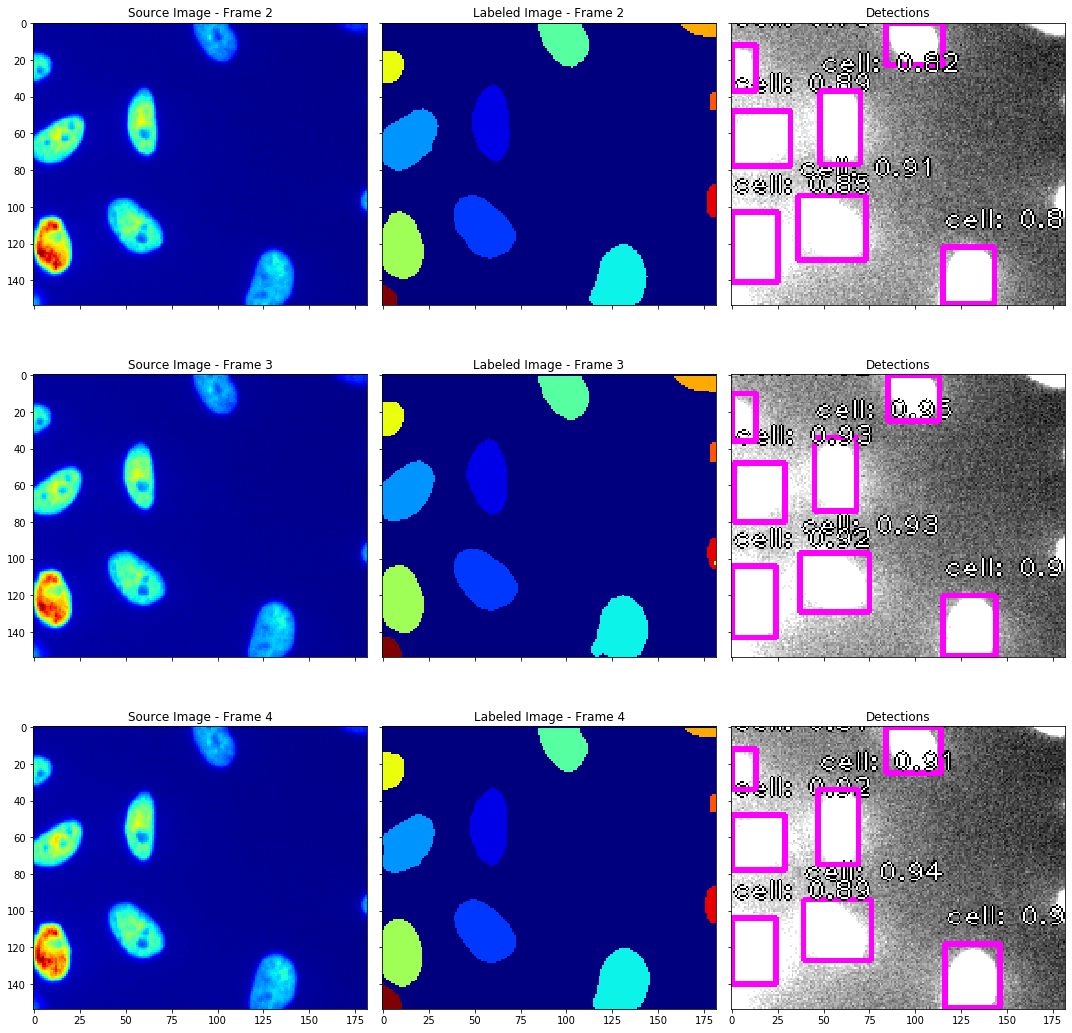

In [30]:
import matplotlib.pyplot as plt
from deepcell.utils.plot_utils import draw_masks, draw_detections

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

draw_list = []

for i in range(fpb):
    draw = 0.1 * np.tile(image[0, i].copy(), (1, 1, 3))

    selection = np.where(final_scores[0, i] > 0.75)[0]

    # draw the masks
    draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
               score_threshold=0.5, binarize_threshold=0.5)

    # draw detections
    draw_detections(draw, boxes[0, i], scores[0, i], labels[0, i],
                    label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()


In [42]:
np.max(assoc_features, axis=-1)

array([[[0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781268, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781288, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0

# Appendix

### Generator Outputs